In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import math
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [53]:
# Инициализируем seed:
RANDOM_SEED = 11
np.random.seed(11)

In [54]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [55]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            
            fout.write("\n{},{}".format(i, int(y)))

In [56]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [57]:
with open('./data_train.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open('./data_test_no_labels.pickle', 'rb') as f:
    test_data = pickle.load(f)
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
X_test = test_data['data']

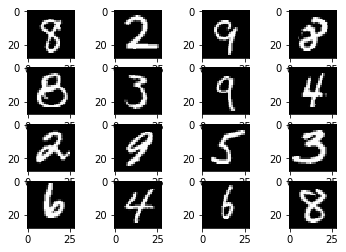

In [58]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [59]:
# Подготовка датасета
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
std[std == 0] = 1e-7
    
x_n=(X_train - mean) / std
x_test_n=(X_test - mean) / std

y_n=Y_train
x_train, x_test, y_train, y_test \
    = train_test_split(x_n, y_n, random_state=RANDOM_SEED)
y_train_ans=y_train
y_train = np.array(list(map(lambda x : encoder.transform(x), y_train)))
y_test_ans=y_test
y_test = np.array(list(map(lambda x : encoder.transform(x), y_test)))


In [60]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b
    
    def backward(self, dz, lr=0.001):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.db - lr * self.db
        return self.dx
    
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr):
        dz[self.x < 0] = 0
        return dz 

    
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat
    
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)
    
   

In [61]:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784,387,rlambda)
        self.m1 = Max()
        self.d2 = Dense(387,10,rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [62]:
# Здесь процедура обучения
net = MnistNet()
loss = CrossEntropy()
lr = 0.00075
L_train = []
L_test = []
train_acc=[]
logtest_acc=[]

for iter in tqdm.tqdm_notebook(range(9)):
    L_acc = 0.
    L_e_acc=0.
    count=0
    counttest=0
    sh = list(range(x_train.shape[0])) 
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
        
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(x_test.shape[0]):
        x = x_test[i]
        y = y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= y_test.shape[0]
    L_test.append(L_e_acc)
    logtest_acc.append(compute_acc(x_test, y_test_ans, net))
    train_acc.append(compute_acc(x_train, y_train_ans, net))
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

0 iter loss. Train : 0.35369394360478307 . Test : 0.25526154880237967
1 iter loss. Train : 0.1685861679534448 . Test : 0.20851521595145095
2 iter loss. Train : 0.1197821076096482 . Test : 0.18622001176257663
3 iter loss. Train : 0.09182748014380654 . Test : 0.1785371056430153
4 iter loss. Train : 0.07337869604052696 . Test : 0.17150427483176878
5 iter loss. Train : 0.06049137044644264 . Test : 0.16678933159444922
6 iter loss. Train : 0.04906488044168683 . Test : 0.16443123335201987
7 iter loss. Train : 0.04190624723506026 . Test : 0.1629096014660832
8 iter loss. Train : 0.035172148034301555 . Test : 0.16054114688749316


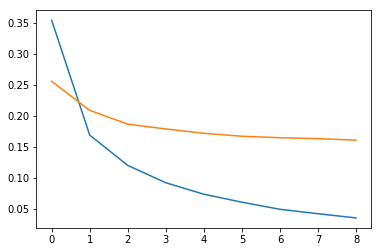

In [64]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label="train")
plt.plot(L_test, label="test")

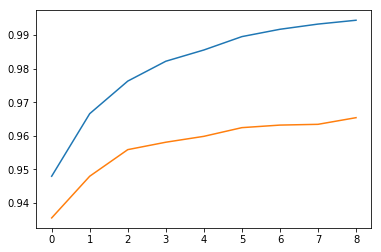

In [65]:
plt.plot(train_acc, label="train")
plt.plot(logtest_acc, label="test")


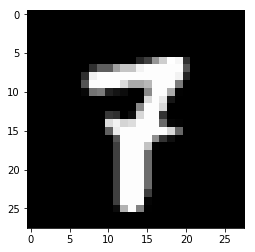

In [296]:
plt.imshow(X_test[29].reshape((28, 28)), cmap='gray' )